# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results, imputation_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
experiment = MIAExperiment(name='Adult')

In [5]:
save_model = True

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Adult
Loaded classifier for experiment from file: Adult


In [208]:
experiment.sensitive_column = experiment.ds.ds.meta['sensitive_column']
experiment.sensitive_positive = experiment.ds.ds.meta['sensitive_positive']
experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_te, experiment.clf)
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.case_2_indices = case_2_indices
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
experiment.sens_val_ground_truth = experiment.X_train[[f'{experiment.sensitive_column}_{experiment.sensitive_positive}']].to_numpy().ravel()
experiment.sens_pred = sens_pred

In [7]:
imputation_aux_dict = {}
aux_df = experiment.ds.ds.df.copy()
married_indices = aux_df[aux_df['marital_Married']==True][aux_df["is_train"]==0][['marital_Married']].index
single_indices = aux_df[aux_df['marital_Married']==False][aux_df["is_train"]==0][['marital_Married']].index

tc_vals = [100, 500, 1000, 2500, 5000]
pcnt_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
for tc in tc_vals:
    for pcnt_s in pcnt_vals:
        pcnt_single = pcnt_s
        total_count = tc
        married_sample_indices = aux_df.loc[married_indices].sample(n=total_count-int(total_count * pcnt_single), replace=False).index
        single_sample_indices = aux_df.loc[single_indices].sample(n=int(total_count * pcnt_single), replace=False).index

        all_sample_indices = married_sample_indices.append(single_sample_indices)
        aux_df_sample = aux_df.loc[all_sample_indices]
        imputation_aux_dict[(tc, pcnt_s)] = aux_df_sample.copy()

In [8]:
experiment.imputation_pred = imputation_attack(experiment, aux_df_onehot=aux_df_sample, subgroup_column='occupation')

In [86]:
imputation_perf_dict = {}
for tc in tc_vals:
    imputation_perf_dict[tc] = {}
    for pcnt_s in pcnt_vals:
        imputation_pred = imputation_attack(experiment, aux_df_onehot=imputation_aux_dict[(tc, pcnt_s)], subgroup_column='occupation')
        imputation_perf_dict[tc][pcnt_s] = round(100 * accuracy_score(experiment.sens_val_ground_truth, imputation_pred), 2)

In [10]:
accuracy_score(experiment.sens_val_ground_truth, sens_pred)

0.699505990574073

In [130]:
print(pd.DataFrame.from_dict(imputation_perf_dict, orient='index').T[[100, 500, 1000, 5000]].round(2).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & 100 & 500 & 1000 & 5000 \\
\midrule
0.100000 & 47.96 & 54.41 & 60.15 & 62.54 \\
0.200000 & 57.79 & 68.95 & 66.93 & 67.68 \\
0.300000 & 64.16 & 71.50 & 70.58 & 71.57 \\
0.400000 & 71.47 & 71.98 & 72.89 & 73.31 \\
0.500000 & 68.84 & 73.43 & 71.82 & 73.46 \\
\bottomrule
\end{tabular}



In [154]:
original_test_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1].copy().reset_index(drop=True).drop(['is_train'], axis=1)

In [237]:
n = (np.array(original_test_df['occupation'].value_counts().tolist()) * 500 / 35222).astype(int)
n[1] = 0
n[4] = 0
n[5] = 0
n[6] = 0
n[8] = 0
p = (np.ones_like(n) * -0.441171595477939).tolist()

In [176]:
p

[-0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939,
 -0.441171595477939]

In [184]:
subgroup_vals = sorted(original_test_df['occupation'].unique().tolist())

In [185]:
subgroup_vals

['Adm-clerical',
 'Armed-Forces',
 'Craft-repair',
 'Exec-managerial',
 'Farming-fishing',
 'Handlers-cleaners',
 'Machine-op-inspct',
 'Other-service',
 'Priv-house-serv',
 'Prof-specialty',
 'Protective-serv',
 'Sales',
 'Tech-support',
 'Transport-moving']

In [ ]:
for i in subgroup_vals:
    print(i)
    print(original_test_df[original_test_df['occupation']==i][['marital', 'income']].value_counts())

In [239]:
indices = experiment.ds.ds.sample_data_matching_correlation(original_test_df, p=p, n=n, subgroup_col_name='occupation', transformed_already=True, return_indices_only=True)

aux_df = experiment.ds.ds.df.copy()
aux_df = aux_df[aux_df["is_train"]==1].copy().reset_index(drop=True).loc[indices].reset_index(drop=True)

X_temp, y_temp = experiment.X_train.loc[indices].copy().reset_index(drop=True), experiment.y_tr[indices]

['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']
[66  0 66 60  0  0  0 25  0 16 15 10  2  0]
{0: {(0, 1): 23, (0, 0): 9, (1, 1): 10, (1, 0): 24}, 1: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}, 2: {(0, 1): 23, (0, 0): 9, (1, 1): 10, (1, 0): 24}, 3: {(0, 1): 21, (0, 0): 8, (1, 1): 9, (1, 0): 22}, 4: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}, 5: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}, 6: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}, 7: {(0, 1): 9, (0, 0): 3, (1, 1): 3, (1, 0): 9}, 8: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}, 9: {(0, 1): 5, (0, 0): 2, (1, 1): 3, (1, 0): 6}, 10: {(0, 1): 5, (0, 0): 2, (1, 1): 2, (1, 0): 5}, 11: {(0, 1): 3, (0, 0): 1, (1, 1): 2, (1, 0): 4}, 12: {(0, 1): 0, (0, 0): 0, (1, 1): 1, (1, 0): 1}, 13: {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}}


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 35.88it/s]


In [233]:
subgroup_col = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col].unique()

conditions = [{subgroup_col: i} for i in subgroup_vals] + [{}]
for condition in conditions:
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, X_temp, y_temp, condition)
    print(condition)
    print(correlation)

{'occupation': 'Prof-specialty'}
-0.44999999999999996
{'occupation': 'Other-service'}
-0.45161290322580644
{'occupation': 'Adm-clerical'}
-0.44312171690790697
{'occupation': 'Craft-repair'}
-0.43976701573170285
{'occupation': 'Farming-fishing'}
nan
{'occupation': 'Machine-op-inspct'}
nan
{'occupation': 'Exec-managerial'}
-0.44079901323976495
{'occupation': 'Priv-house-serv'}
nan
{'occupation': 'Sales'}
-0.444749589996661
{'occupation': 'Transport-moving'}
nan
{'occupation': 'Handlers-cleaners'}
nan
{'occupation': 'Protective-serv'}
-0.4358974358974359
{'occupation': 'Tech-support'}
-0.5773502691896257
{'occupation': 'Armed-Forces'}
nan
{}
-0.44395213379544857


In [39]:
subgroup_col = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col].unique()

conditions = [{subgroup_col: i} for i in subgroup_vals] + [{}]
for condition in conditions:
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    print(condition)
    print(correlation)

{'occupation': 'Prof-specialty'}
-0.5393493524000169
{'occupation': 'Other-service'}
-0.26113058134433104
{'occupation': 'Adm-clerical'}
-0.5110348526374976
{'occupation': 'Craft-repair'}
-0.31311634960390927
{'occupation': 'Farming-fishing'}
-0.2299897920101619
{'occupation': 'Machine-op-inspct'}
-0.3276462094331777
{'occupation': 'Exec-managerial'}
-0.49050579222648905
{'occupation': 'Priv-house-serv'}
-0.1665986628369903
{'occupation': 'Sales'}
-0.4856204599179692
{'occupation': 'Transport-moving'}
-0.29804129465916873
{'occupation': 'Handlers-cleaners'}
-0.3053044386004156
{'occupation': 'Protective-serv'}
-0.3741917581018578
{'occupation': 'Tech-support'}
-0.5534833405745625
{'occupation': 'Armed-Forces'}
-0.7200822998230957
{}
-0.441171595477939


In [240]:
imputation_pred = imputation_attack(experiment, aux_df_onehot=aux_df, subgroup_column='occupation', is_train=1)
imputation_pred_ideal = imputation_attack(experiment, aux_df_onehot=aux_df_ideal, subgroup_column='occupation', is_train=1)

correlation_vs_ang_diff = {}
subgroup_col_name = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()

conditions = [{}] + [{subgroup_col_name: i} for i in subgroup_vals]
for i, condition in enumerate(conditions):
    # condition = {subgroup_col_name: i}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['subgroup_val'] = subgroup_vals[i-1] if i>0 else {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['correlation_diff'] = np.abs(correlation + 0.441171595477939)
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == sens_pred_LOMIA[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['imputation_accuracy'] = (experiment.sens_val_ground_truth[indices] == imputation_pred[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['imputation_accuracy_ideal'] = (experiment.sens_val_ground_truth[indices] == imputation_pred_ideal[indices]).sum()/len(indices)


correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

/Users/ehsanulkabir/Downloads/tabular/disparity_inference_utils.py:175: RankWarning: Polyfit may be poorly conditioned
  return [np.polyfit(confidence_array[indices_by_y_values[y_value], 1], confidence_array[indices_by_y_values[y_value], 0], 1)[0] for y_value in y_values]
/Users/ehsanulkabir/Downloads/tabular/disparity_inference_utils.py:175: RankWarning: Polyfit may be poorly conditioned
  return [np.polyfit(confidence_array[indices_by_y_values[y_value], 1], confidence_array[indices_by_y_values[y_value], 0], 1)[0] for y_value in y_values]


In [241]:
correlation_vs_ang_diff_df.sort_values(by='correlation')[['subgroup_val', 'correlation', 'CSMIA_attack_accuracy', 'imputation_accuracy']]

,subgroup_val,correlation,CSMIA_attack_accuracy,imputation_accuracy
{'occupation': 'Armed-Forces'},Armed-Forces,-0.720082,0.846154,0.384615
{'occupation': 'Tech-support'},Tech-support,-0.553483,0.776000,0.741333
{'occupation': 'Prof-specialty'},Prof-specialty,-0.539349,0.756631,0.727562
{'occupation': 'Adm-clerical'},Adm-clerical,-0.511035,0.816065,0.773458
{'occupation': 'Exec-managerial'},Exec-managerial,-0.490506,0.733945,0.756774
{'occupation': 'Sales'},Sales,-0.485620,0.729429,0.744605
{},{},-0.441172,0.699648,0.704134
{'occupation': 'Protective-serv'},Protective-serv,-0.374192,0.618611,0.638270
{'occupation': 'Machine-op-inspct'},Machine-op-inspct,-0.327646,0.611940,0.620720
{'occupation': 'Craft-repair'},Craft-repair,-0.313116,0.558993,0.596970


In [261]:
temp_df = correlation_vs_ang_diff_df.sort_values(by='correlation_diff')[['subgroup_val', 'correlation', 'CSMIA_attack_accuracy', 'LOMIA_attack_accuracy', 'imputation_accuracy', 'imputation_accuracy_ideal']]
temp_df = temp_df[temp_df['correlation'] < -0.45]
temp_df.index = temp_df['subgroup_val'].to_numpy()
temp_df = temp_df.drop(['subgroup_val'], axis=1)
temp_df = temp_df.drop(['Armed-Forces'], axis=0)

In [259]:
temp_df

,correlation,CSMIA_attack_accuracy,LOMIA_attack_accuracy,imputation_accuracy,imputation_accuracy_ideal
Adm-clerical,-0.511035,0.816065,0.816764,0.773458,0.808382
Prof-specialty,-0.539349,0.756631,0.765754,0.727562,0.769786
Tech-support,-0.553483,0.776000,0.775111,0.741333,0.743111


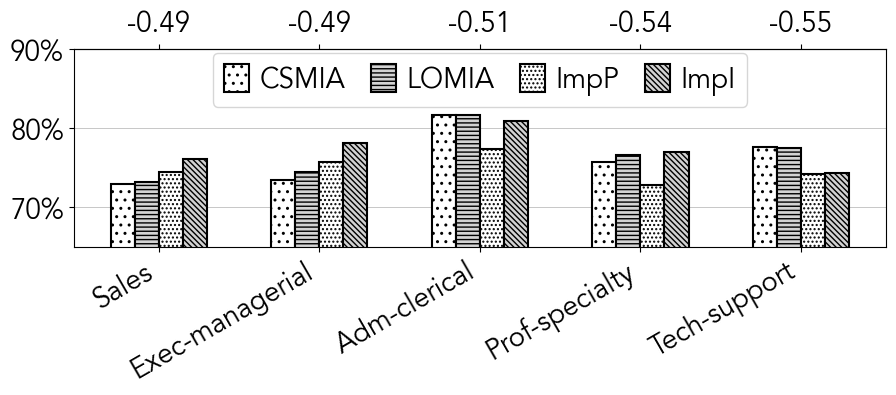

In [263]:
df = temp_df.copy()

hatches = ['0..', '----', '....', '\\\\\\\\\\\\', '--..', '//////', 'o', 'O', '.', '*']
alphas = [0.1, 0.9] * 4
fontsize = 20
colors = ['#FFFFFF', '#D3D3D3']

# Plotting
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir'
# Plotting
fig, ax = plt.subplots(figsize=(9, 4))
plt.grid(True, linewidth=0.5, axis='y', zorder=0)

# Define the number of bars
n_bars = len(df)

# Define the width of each bar
bar_width = 0.15

# The positions of the bars on the x-axis
bar_positions = np.arange(n_bars)

# Create the bars for 'CSMIA_attack_accuracy'
ax.bar(bar_positions - 3 * bar_width / 2, 100 * df['CSMIA_attack_accuracy'], width=bar_width, label='CSMIA', hatch=hatches[0], color=colors[0], edgecolor='black', linewidth=1.5, zorder=2)

# Create the bars for 'CSMIA_attack_accuracy'
ax.bar(bar_positions - bar_width/2, 100 * df['LOMIA_attack_accuracy'], width=bar_width, label='LOMIA', hatch=hatches[1], color=colors[1], edgecolor='black', linewidth=1.5, zorder=2)

# Create the bars for 'imputation_accuracy'
ax.bar(bar_positions + bar_width/2, 100 * df['imputation_accuracy'], width=bar_width, label='ImpP', hatch=hatches[2], color=colors[0], edgecolor='black', linewidth=1.5, zorder=2)

# Create the bars for 'imputation_accuracy'
ax.bar(bar_positions + 3* bar_width / 2, 100 * df['imputation_accuracy_ideal'], width=bar_width, label='ImpI', hatch=hatches[3], color=colors[1], edgecolor='black', linewidth=1.5, zorder=2)

ax.set_ylim(65, 90)
# Labeling the x-axis with job categories
ax.set_xticks(bar_positions)
ax.set_xticklabels(df.index, fontsize=fontsize, rotation=30, ha='right')

ax.set_yticks(np.arange(70, 100, 10))
ax.set_yticklabels([f'{i:.0f}%' for i in np.arange(70, 100, 10)], fontsize=fontsize)

secax = ax.secondary_xaxis('top')

# Set the ticks and labels for the secondary x-axis
secax.set_xticks(bar_positions)
secax.set_xticklabels([f'{correlation:.2f}' for correlation in df['correlation']], fontsize=fontsize)

# Set labels and title
# ax.set_xlabel('Job Category')
# ax.set_ylabel('Accuracy')
# ax.set_title('CSMIA Attack Accuracy vs Imputation Accuracy by Job Category')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=len(df.columns), fontsize=fontsize, prop={'size': fontsize}, handlelength=0.9, handleheight=1.2, columnspacing=0.9, handletextpad=0.4)

# Add a legend
# ax.legend()

# Show the plot
plt.tight_layout()
plt.show()